In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

# from spin import *
# from trotter import *
import time

In [ ]:
class Nearest_Neighbour_1d:
    def __init__(self, n: int, Jx=0, Jy=0, Jz=0, hx=0, hy=0, hz=0, pbc=False, verbose=False, rand_field=[]):
        self.n = n
        self.Jx, self.Jy, self.Jz = Jx, Jy, Jz
        self.hx, self.hy, self.hz = hx, hy, hz

        self.xx_tuples = [('XX', [i, i + 1], Jx) for i in range(0, n-1)]
        self.yy_tuples = [('YY', [i, i + 1], Jy) for i in range(0, n-1)]
        self.zz_tuples = [('ZZ', [i, i + 1], Jz) for i in range(0, n-1)]

        if len(rand_field) == 0:
            self.rand_field = [0]*n
        elif len(rand_field) >= n:
            self.rand_field = rand_field[:n]
        else:
            raise ValueError(f'Length of random field should be at least {n}!')

        self.x_tuples = [('X', [i], (self.rand_field[i]+1)*hx) for i in range(0, n)] 
        self.y_tuples = [('Y', [i], (self.rand_field[i]+1)*hy) for i in range(0, n)] 
        self.z_tuples = [('Z', [i], (self.rand_field[i]+1)*hz) for i in range(0, n)] 

        if pbc: 
            self.xx_tuples.append(('XX', [n-1, 0], Jx))
            self.yy_tuples.append(('YY', [n-1, 0], Jy))
            self.zz_tuples.append(('ZZ', [n-1, 0], Jz))

        self.ham = SparsePauliOp.from_sparse_list([*self.xx_tuples, *self.yy_tuples, *self.zz_tuples, *self.x_tuples, *self.y_tuples, *self.z_tuples], num_qubits=n).simplify() 
        self.xyz_group()
        self.par_group()
        if verbose: 
            print('The Hamiltonian: \n', self.ham)
            print('The xyz grouping: \n', self.ham_xyz)
            print('The parity grouping: \n', self.ham_par)

    def xyz_group(self):
        self.x_terms = SparsePauliOp.from_sparse_list([*self.xx_tuples, *self.x_tuples], num_qubits=self.n).simplify()
        self.y_terms = SparsePauliOp.from_sparse_list([*self.yy_tuples, *self.y_tuples], num_qubits=self.n).simplify()
        self.z_terms = SparsePauliOp.from_sparse_list([*self.zz_tuples, *self.z_tuples], num_qubits=self.n).simplify()
        self.ham_xyz = [self.x_terms, self.y_terms, self.z_terms]
        self.ham_xyz = [item for item in self.ham_xyz if not np.all(abs(item.coeffs) == 0)]

    def par_group(self):
        self.even_terms = SparsePauliOp.from_sparse_list([*self.xx_tuples[::2], *self.yy_tuples[::2], *self.zz_tuples[::2], *self.x_tuples[::2], *self.y_tuples[::2], *self.z_tuples[::2]], num_qubits=self.n).simplify()
        self.odd_terms = SparsePauliOp.from_sparse_list([*self.xx_tuples[1::2], *self.yy_tuples[1::2], *self.zz_tuples[1::2], *self.x_tuples[1::2], *self.y_tuples[1::2], *self.z_tuples[1::2]], num_qubits=self.n).simplify()
        self.ham_par = [self.even_terms, self.odd_terms]

    # def lc_group(self, right, left, step):
    #     self.ham_lc = []



In [4]:
simulator_gpu = AerSimulator(method='statevector', device='CPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

('CPU',)
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop')


In [14]:
n = 20

QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)

H = QIMF.ham_xyz
print(H)

init = Statevector.from_label("10"*int(n/2))
# init = Statevector.from_label("101010101010")
t = 20
r = 100
m = 1
dt = (t / r)
dt2 = (t / (r*m))

print(dt, dt2)

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIXXI', 'IIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIXXIII', 'IIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIXXIIIIIIIII', 'IIIIIIIIXXIIIIIIIIII', 'IIIIIIIXXIIIIIIIIIII', 'IIIIIIXXIIIIIIIIIIII', 'IIIIIXXIIIIIIIIIIIII', 'IIIIXXIIIIIIIIIIIIII', 'IIIXXIIIIIIIIIIIIIII', 'IIXXIIIIIIIIIIIIIIII', 'IXXIIIIIIIIIIIIIIIII', 'XXIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIXIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIII', 'IIIIXIIIIIIIIIIIIIII', 'IIIXIIIIIIIIIIIIIIII', 'IIXIIIIIIIIIIIIIIIII', 'IXIIIIIIIIIIIIIIIIII', 'XIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1. 

In [15]:
from qiskit.synthesis import SuzukiTrotter

trotter_step_first_order = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())

trotter_step_second_order = PauliEvolutionGate(H, time=dt2, synthesis=SuzukiTrotter())

start_time = time.time()
data, data2 = [], []
ideal_psi = init
total_steps = r*m - 1

for s in range(1, r+1):
  # circ_pf2 = circuit.copy()

  # circ2 = qc.copy()
  circ_pf1 = QuantumCircuit(n)
  circ_pf1.set_statevector(ideal_psi)
  circ_pf1.append(trotter_step_first_order, range(n))
  circ_pf1.save_statevector(label=f"sv_{s}")

  circ_pf1 = circ_pf1.decompose(reps=2)
  res = simulator_gpu.run(circ_pf1).result()
  psi = res.data(0)[f"sv_{s}"]
  data.append(psi)

  for ss in range (1, m+1):
    print("step:", ss)
    circ_pf2 = QuantumCircuit(n)
    circ_pf2.set_statevector(ideal_psi)
    circ_pf2.append(trotter_step_second_order, range(n))
    circ_pf2 = circ_pf2.decompose(reps=2)
    circ_pf2.save_statevector(label=f"temp_{total_steps}")

    res2 = simulator_gpu.run(circ_pf2).result()
    temp = res2.data(0)[f"temp_{total_steps}"]
    ideal_psi = temp
    # print(f"temp_{ss}")
    total_steps -= 1

  ideal_psi = res2.data(0)[f"temp_{total_steps + 1}"]
  data2.append(ideal_psi)
  print(np.linalg.norm(ideal_psi - psi))

  print("pf1 step:", s)

better_states = data2
states = data

total_time = time.time() - start_time
print("total time", total_time)

step: 1
0.3238416223690346
pf1 step: 1
step: 1
0.2891902372808651
pf1 step: 2
step: 1
0.41140361897232003
pf1 step: 3
step: 1
0.38576010947666123
pf1 step: 4
step: 1
0.2457571433221274
pf1 step: 5
step: 1
0.30371446012263237
pf1 step: 6
step: 1
0.21884975438767296
pf1 step: 7
step: 1
0.25178733469139775
pf1 step: 8
step: 1
0.2639914495599341
pf1 step: 9
step: 1
0.2646984089190185
pf1 step: 10
step: 1
0.2677681072704051
pf1 step: 11
step: 1
0.273809305707067
pf1 step: 12
step: 1
0.27327864363850796
pf1 step: 13
step: 1
0.2788084245116339
pf1 step: 14
step: 1
0.2788967212373607
pf1 step: 15
step: 1
0.2602482408793736
pf1 step: 16
step: 1
0.25389336818243863
pf1 step: 17
step: 1
0.26070562095142935
pf1 step: 18
step: 1
0.2492252473481698
pf1 step: 19
step: 1
0.24831716334632511
pf1 step: 20
step: 1
0.25682818323127404
pf1 step: 21
step: 1
0.2595173363565947
pf1 step: 22
step: 1
0.26173480816986244
pf1 step: 23
step: 1
0.26532265718428255
pf1 step: 24
step: 1
0.26294832596090695
pf1 step: 

In [16]:
entropy_list = []
entropy_list2 = []

for s in range(1, r+1):
    rdm1 = partial_trace(states[s-1], list(range(1, n)))
    rdm2 = partial_trace(states[s-1], list(range(2, n)))
    rdm3 = partial_trace(states[s-1], list(range(3, n)))
    rdm4 = partial_trace(states[s-1], list(range(4, n)))
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(s, temp_entropy)

    rdm12 = partial_trace(better_states[s-1], list(range(1, n)))
    rdm22 = partial_trace(better_states[s-1], list(range(2, n)))
    rdm32 = partial_trace(better_states[s-1], list(range(3, n)))
    rdm42 = partial_trace(better_states[s-1], list(range(4, n)))
    temp_entropy2 = [entropy(rdm12), entropy(rdm22), entropy(rdm32), entropy(rdm42)]
    print(temp_entropy2)

    entropy_list.append(temp_entropy)
    entropy_list2.append(temp_entropy2)

1 [0.2398545710433934, 0.23985457104340485, 0.23985457104340932, 0.23985457104341962]
[0.2173226931915487, 0.21753191752174494, 0.2175319175217527, 0.21753191752176756]
2 [0.5306954453827538, 0.5319544749654713, 0.5319544749654989, 0.531954474965524]
[0.47839450899777175, 0.47949506929517843, 0.4794651163183127, 0.4794651163183397]
3 [0.611851384136845, 0.6191704057268668, 0.6190918113109779, 0.6190918113109879]
[0.5877178768767539, 0.5898855165845229, 0.5897268166394726, 0.5897204428112294]
4 [0.5622598856671154, 0.5929739397273979, 0.5928768065738046, 0.5928580612414268]
[0.5724623769331803, 0.6122578194506116, 0.6125604024842156, 0.6124784744530902]
5 [0.5015303756342012, 0.665308137964312, 0.6673179073559343, 0.6671217046037867]
[0.5206673112827761, 0.7082102556667923, 0.7104079653260874, 0.7100624940956877]
6 [0.5023388722237179, 0.8871621394087479, 0.8928495840711091, 0.8922358458820647]
[0.5234126222894304, 0.9030894651970016, 0.9137132724570562, 0.9129821446520571]
7 [0.6006223

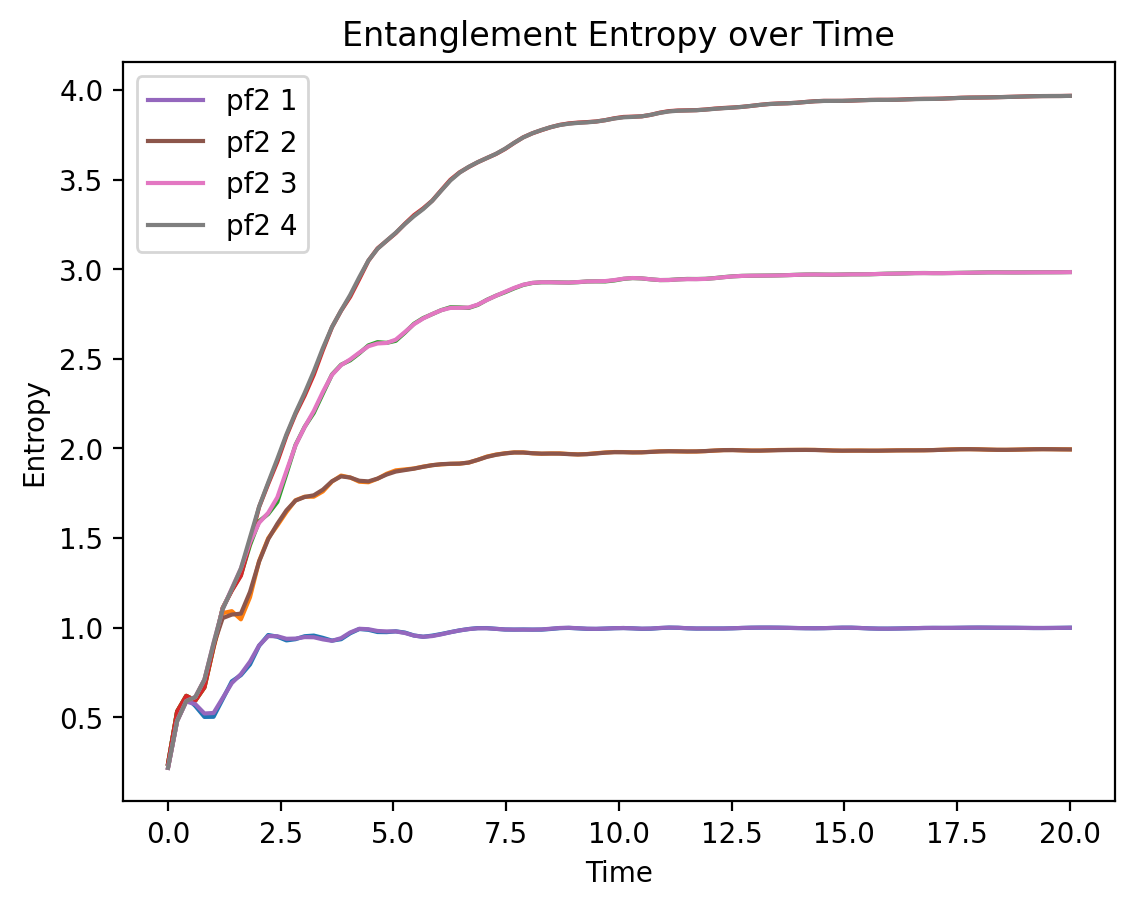

In [17]:
import matplotlib.pyplot as plt
import numpy as np

dt = t/r
steps = len(entropy_list)
times = np.linspace(0, t, 100)

# Extract the first element of each sublist in entropy_list
entropy_values_1 = [entropy[0] for entropy in entropy_list]
entropy_values_2 = [entropy[1] for entropy in entropy_list]
entropy_values_3 = [entropy[2] for entropy in entropy_list]
entropy_values_4 = [entropy[3] for entropy in entropy_list]


# Extract the first element of each sublist in entropy_list2
entropy_values_12 = [entropy[0] for entropy in entropy_list2]
entropy_values_22 = [entropy[1] for entropy in entropy_list2]
entropy_values_32 = [entropy[2] for entropy in entropy_list2]
entropy_values_42 = [entropy[3] for entropy in entropy_list2]

# Create the plot
plt.plot(times, entropy_values_1)
plt.plot(times, entropy_values_2)
plt.plot(times, entropy_values_3)
plt.plot(times, entropy_values_4)

plt.plot(times, entropy_values_12, label='pf2 1')
plt.plot(times, entropy_values_22, label='pf2 2')
plt.plot(times, entropy_values_32, label='pf2 3')
plt.plot(times, entropy_values_42, label='pf2 4')

plt.xlabel("Time")
plt.ylabel("Entropy")
plt.title("Entanglement Entropy over Time")
plt.legend()
plt.show()

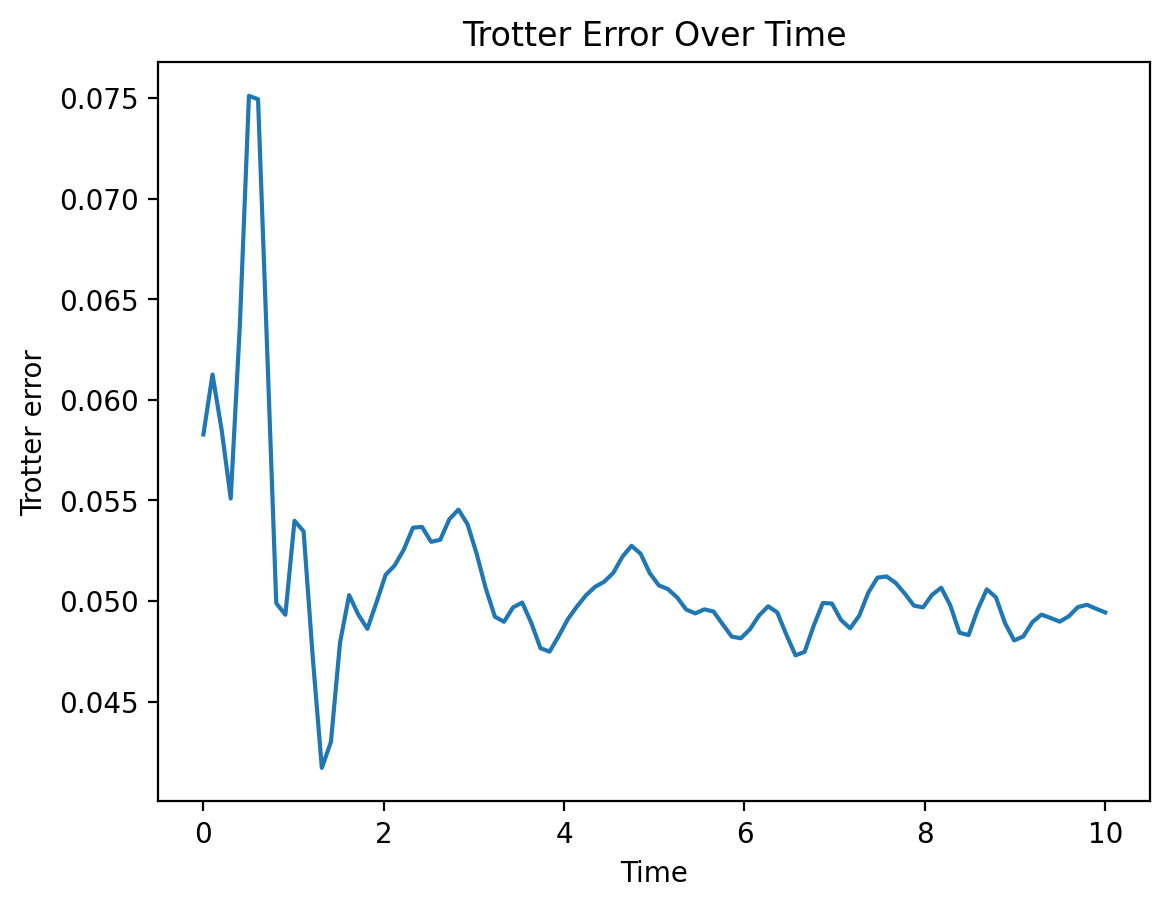

In [15]:
trotter = []
for s in range(0, r):
  tro = np.linalg.norm(better_states[s] - states[s])
  # print(tro)
  trotter.append(tro)

plt.plot(times, trotter)
plt.xlabel("Time")
plt.ylabel("Trotter error")
plt.title("Trotter Error Over Time")
plt.show()